In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

# Dossiers
DATA_RAW = Path("data/raw")
DATA_PROC = Path("data/processed")
MODELS_DIR = Path("models")
ARTIF_DIR = Path("artifacts/reports")
for p in [DATA_RAW, DATA_PROC, MODELS_DIR, ARTIF_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("OK dossiers:", DATA_RAW.resolve(), DATA_PROC.resolve(), MODELS_DIR.resolve())

OK dossiers: /home/nicolasd/code/nicolasdestrac/OpenClassrooms/Projet_7/data/raw /home/nicolasd/code/nicolasdestrac/OpenClassrooms/Projet_7/data/processed /home/nicolasd/code/nicolasdestrac/OpenClassrooms/Projet_7/models


In [2]:
# Visu
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from src.metrics import make_business_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Explicabilité
import shap

# MLOps
import mlflow
import os
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature
import joblib
import json
from dotenv import load_dotenv
load_dotenv()

# Réglages d’affichage
%matplotlib inline

/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "databricks"))
mlflow.set_registry_uri(os.getenv("MLFLOW_TRACKING_URI", "databricks"))
exp_path = os.getenv("MLFLOW_EXPERIMENT", "/Users/nicolas.destrac@gmail.com/projet7_scoring")
mlflow.set_experiment(exp_path)

# contrôle
client = MlflowClient()
exp = client.get_experiment_by_name(exp_path)
print("Tracking URI ->", mlflow.get_tracking_uri())
print("Experiment    ->", exp.name)
print("Artifact Loc  ->", exp.artifact_location)

Tracking URI -> databricks
Experiment    -> /Users/nicolas.destrac@gmail.com/projet7
Artifact Loc  -> dbfs:/databricks/mlflow-tracking/3880182794298532


In [4]:
train_path = DATA_RAW / "application_train.csv"
test_path  = DATA_RAW / "application_test.csv"

assert train_path.exists(), f"Manque {train_path} (place dans data/raw)"
assert test_path.exists(),  f"Manque {test_path} (place dans data/raw)"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

train.shape, test.shape

((307511, 122), (48744, 121))

In [5]:
# Verification que la cible ne soit que dans le train
col_list = [col for col in list(train.columns) if col not in list(test.columns)]
col_list

['TARGET']

In [6]:
train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
display(train.dtypes.value_counts())

# Stats numériques (aperçu)
display(train.describe(include="number").T.head(15))

# % de NaN
na_pct = train.isna().mean().sort_values(ascending=False).to_frame("missing_rate")
na_pct.head(20)

float64    65
int64      41
object     16
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.00000,189145.500000,278202.00000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.00000,0.000000,0.00000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.00000,0.000000,0.00000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.00000,112500.000000,147150.00000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.00000,270000.000000,513531.00000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.50000,16524.000000,24903.00000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.00000,238500.000000,450000.00000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.00029,0.010006,0.01885,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.00000,-19682.000000,-15750.00000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.00000,-2760.000000,-1213.00000,-289.000000,3.652430e+05


,missing_rate
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_MODE,0.683550


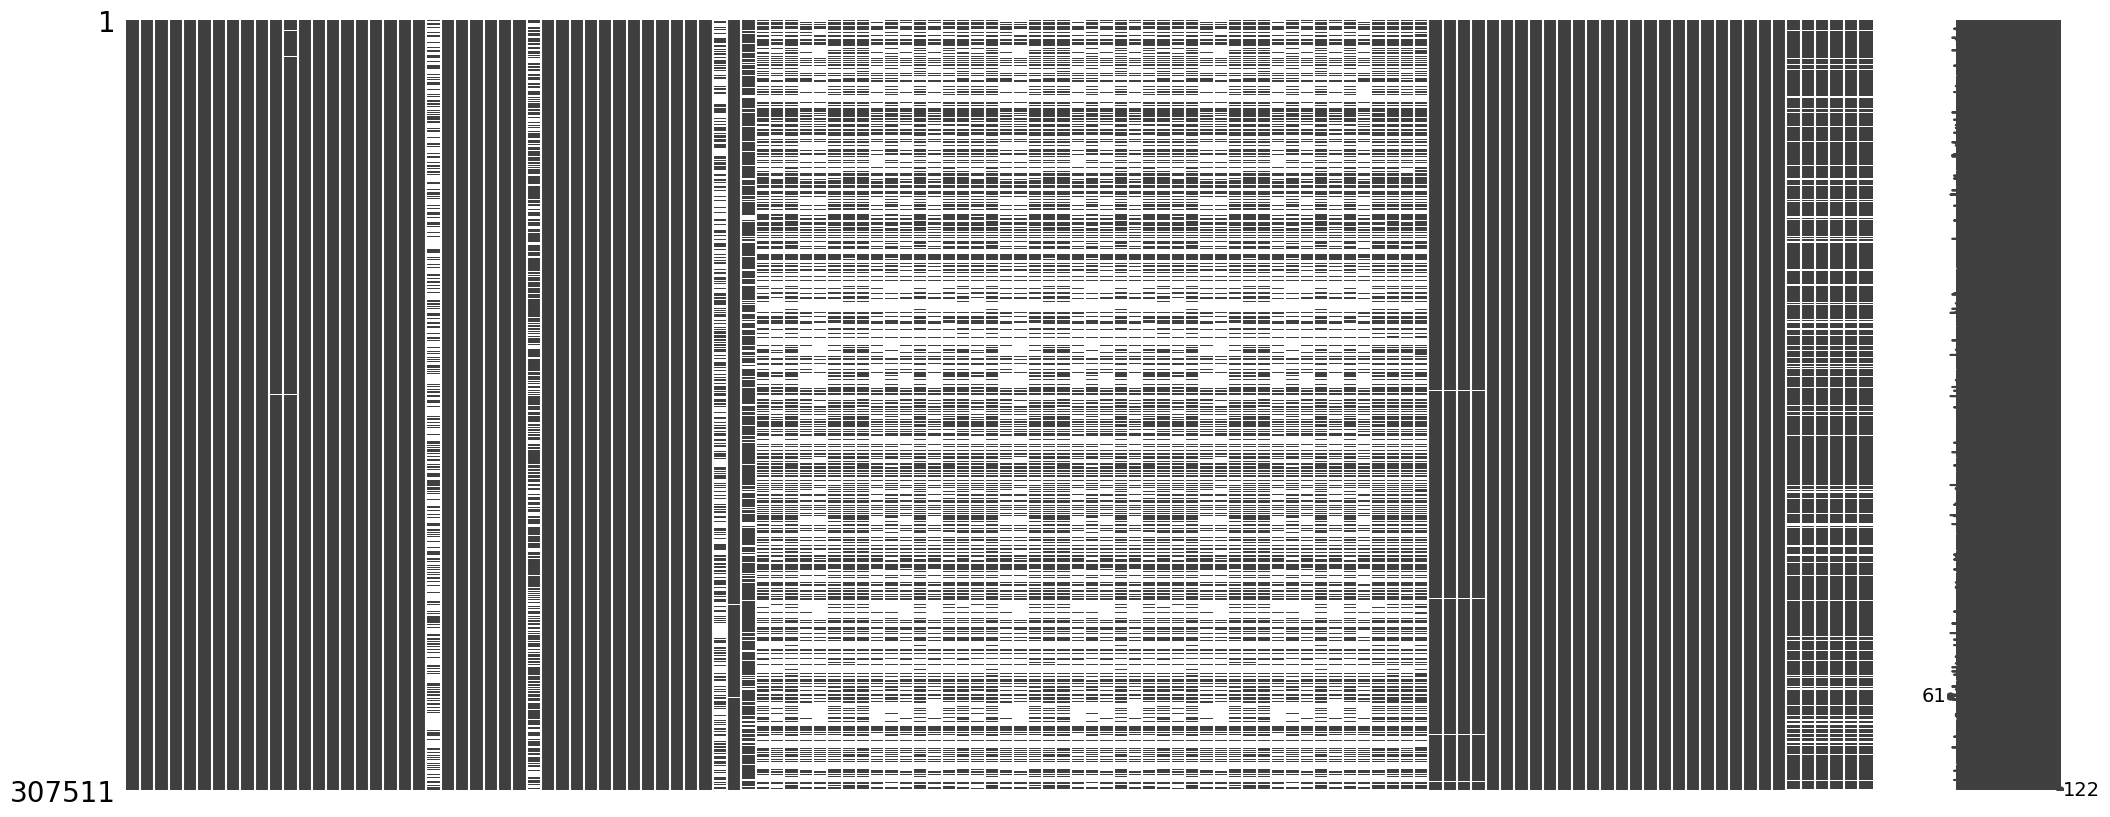

In [8]:
msno.matrix(train);

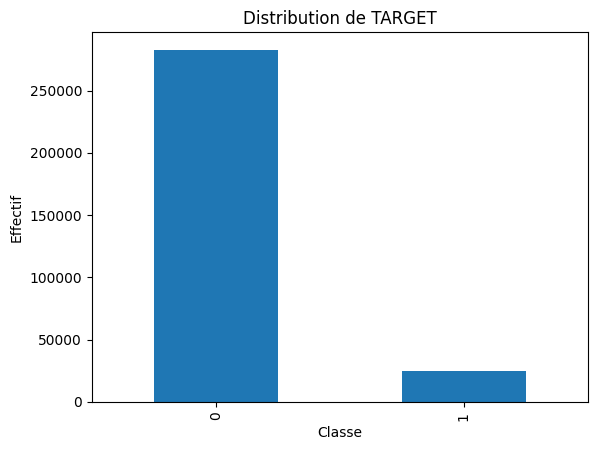

TARGET
0    0.9193
1    0.0807
Name: count, dtype: float64

In [9]:
target_counts = train["TARGET"].value_counts()
ax = target_counts.plot(kind="bar")
ax.set_title("Distribution de TARGET"); ax.set_xlabel("Classe"); ax.set_ylabel("Effectif")
plt.show()

(target_counts/len(train)).round(4)

In [10]:
# Feature engineering
for df in (train, test):
    df.loc[df["DAYS_EMPLOYED"] > 365000, "DAYS_EMPLOYED"] = np.nan
    df["AGE_YEARS"] = (-df["DAYS_BIRTH"] / 365).astype(float)
    df["EMP_YEARS"] = (-df["DAYS_EMPLOYED"] / 365)

    df["CREDIT_INCOME_RATIO"] = df["AMT_CREDIT"] / (df["AMT_INCOME_TOTAL"] + 1e-6)
    df["ANNUITY_INCOME_RATIO"] = df["AMT_ANNUITY"] / (df["AMT_INCOME_TOTAL"] + 1e-6)
    df["ANNUITY_CREDIT_RATIO"] = df["AMT_ANNUITY"] / (df["AMT_CREDIT"] + 1e-6)
    df["GOODS_CREDIT_RATIO"]  = df["AMT_GOODS_PRICE"] / (df["AMT_CREDIT"] + 1e-6)

    for a,b in [("EXT_SOURCE_1","EXT_SOURCE_2"), ("EXT_SOURCE_2","EXT_SOURCE_3"), ("EXT_SOURCE_1","EXT_SOURCE_3")]:
        if a in df.columns and b in df.columns:
            df[f"{a}_x_{b}"]    = df[a] * df[b]
            df[f"{a}_plus_{b}"] = df[a] + df[b]

In [11]:
y = train["TARGET"]
X = train.drop(columns=["TARGET"])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_valid.shape

((246008, 133), (61503, 133))

In [12]:
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),  # compat. sparse
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

len(num_cols), len(cat_cols)

(117, 16)

In [13]:
def eval_auc(model, X_tr, y_tr, X_va, y_va):
    p_tr = model.predict_proba(X_tr)[:,1]
    p_va = model.predict_proba(X_va)[:,1]
    return roc_auc_score(y_tr, p_tr), roc_auc_score(y_va, p_va)

In [14]:
results = []

# 1) Logistic Regression (ponderation classes)
logreg = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])
logreg.fit(X_train, y_train)
auc_tr, auc_va = eval_auc(logreg, X_train, y_train, X_valid, y_valid)
results.append(("LogReg", auc_tr, auc_va))

# 2) RandomForest
rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced_subsample"
    ))
])
rf.fit(X_train, y_train)
auc_tr, auc_va = eval_auc(rf, X_train, y_train, X_valid, y_valid)
results.append(("RandomForest", auc_tr, auc_va))

# 3) LightGBM (params simples)
lgbm = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", lgb.LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=64,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
])
lgbm.fit(X_train, y_train)
auc_tr, auc_va = eval_auc(lgbm, X_train, y_train, X_valid, y_valid)
results.append(("LightGBM", auc_tr, auc_va))

pd.DataFrame(results, columns=["model","auc_train","auc_valid"]).sort_values("auc_valid", ascending=False)

/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14759
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 246
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,auc_train,auc_valid
2,LightGBM,0.930568,0.766911
0,LogReg,0.751681,0.751054
1,RandomForest,1.000000,0.745732


In [15]:
COST_FN = 10.0  # coût faux négatif (accorder un mauvais client)
COST_FP = 1.0   # coût faux positif (refuser un bon client)

def business_cost(y_true, y_prob, threshold=0.5, cost_fn=COST_FN, cost_fp=COST_FP):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return fn * cost_fn + fp * cost_fp

def find_best_threshold(y_true, y_prob, cost_fn=COST_FN, cost_fp=COST_FP):
    thresholds = np.linspace(0.01, 0.99, 99)
    costs = [business_cost(y_true, y_prob, t, cost_fn, cost_fp) for t in thresholds]
    best_idx = int(np.argmin(costs))
    return float(thresholds[best_idx]), float(costs[best_idx])

# On prend le meilleur modèle AUC
best_model = lgbm
y_valid_prob = best_model.predict_proba(X_valid)[:,1]
best_th, best_cost = find_best_threshold(y_valid, y_valid_prob)
auc_val = roc_auc_score(y_valid, y_valid_prob)

print(f"AUC valid = {auc_val:.4f}")
print(f"Seuil métier optimal = {best_th:.3f} | Coût validation = {best_cost:.1f}")

/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC valid = 0.7669
Seuil métier optimal = 0.080 | Coût validation = 32058.0


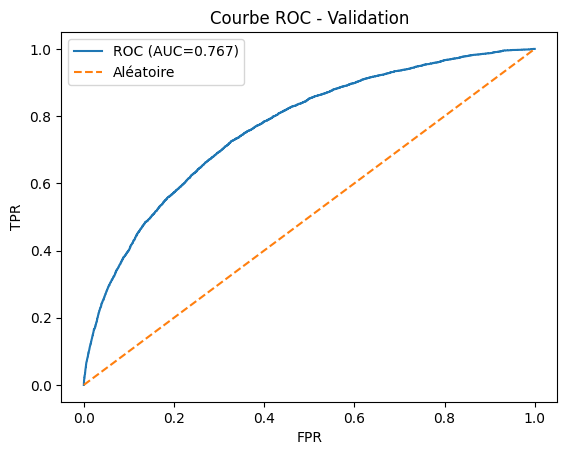

Seuil choisi (métier) = 0.080


In [16]:
fpr, tpr, thr = roc_curve(y_valid, y_valid_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],"--", label="Aléatoire")
plt.title("Courbe ROC - Validation")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

print(f"Seuil choisi (métier) = {best_th:.3f}")

In [17]:
def mem_mb(df):
    return df.memory_usage(deep=True).sum() / 1024**2

print(f"RAM train: {mem_mb(train):.1f} MB | RAM test: {mem_mb(test):.1f} MB")

dtype_counts_train = train.dtypes.value_counts()
dtype_counts_test  = test.dtypes.value_counts()
dtype_counts_train, dtype_counts_test

RAM train: 564.8 MB | RAM test: 89.2 MB


(float64    78
 int64      40
 object     16
 Name: count, dtype: int64,
 float64    78
 int64      39
 object     16
 Name: count, dtype: int64)

In [18]:
na_pct = train.isna().mean().sort_values(ascending=False).to_frame("missing_rate")
na_pct.head(25)

,missing_rate
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_AVG,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MODE,0.683550


In [19]:
def oof_auc_and_cost(model, X, y, cost_fn=COST_FN, cost_fp=COST_FP, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_prob = np.zeros(len(y))
    for tr, va in skf.split(X, y):
        model.fit(X.iloc[tr], y.iloc[tr])
        oof_prob[va] = model.predict_proba(X.iloc[va])[:,1]
    auc = roc_auc_score(y, oof_prob)
    ths = np.linspace(0.01, 0.99, 99)
    def cost_at(t):
        y_pred = (oof_prob >= t).astype(int)
        fp = ((y_pred==1) & (y==0)).sum()
        fn = ((y_pred==0) & (y==1)).sum()
        return fn*cost_fn + fp*cost_fp
    costs = [(t, cost_at(t)) for t in ths]
    best_th, best_cost = min(costs, key=lambda x: x[1])
    return auc, best_th, best_cost, oof_prob

In [20]:
auc_oof, th_oof, cost_oof, oof_prob = oof_auc_and_cost(best_model, X, y)
print(f"AUC OOF = {auc_oof:.4f} | Seuil OOF = {th_oof:.3f} | Coût OOF = {cost_oof:.0f}")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14688
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14778
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14680
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 246
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14687
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14679
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC OOF = 0.7634 | Seuil OOF = 0.080 | Coût OOF = 160830


In [21]:
# Normalisation du coût (pour 10 000 clients)
best_cost_norm = (best_cost / len(y_valid)) * 10_000
cost_oof_norm = (cost_oof / len(y)) * 10_000

In [22]:
print(f'Coût de validation train/test split : {best_cost_norm}')
print(f'Coût de validation OOF : {cost_oof_norm}')

Coût de validation train/test split : 5212.428662016488
Coût de validation OOF : 5230.056810975867


In [23]:
with mlflow.start_run(run_name="baseline_notebook_remote") as run:
    # Params & métriques
    mlflow.log_param("cost_fn", float(COST_FN))
    mlflow.log_param("cost_fp", float(COST_FP))
    mlflow.log_metric("auc_valid_or_oof", float(auc_val))
    mlflow.log_metric("best_threshold", float(best_th))
    mlflow.log_metric("business_cost", float(best_cost))

    # Artifacts
    Path("models").mkdir(exist_ok=True)
    joblib.dump(best_model, "models/scoring_model.joblib")
    with open("models/decision_threshold.json", "w") as f:
        json.dump({"threshold": float(best_th),
                   "cost_fn": float(COST_FN),
                   "cost_fp": float(COST_FP)}, f)
    mlflow.log_artifact("models/decision_threshold.json")

    # On ajoute une signature pour éviter le warning
    try:
        # petit échantillon pour la signature (X_valid existe déjà dans le carnet)
        sig = infer_signature(X_valid.iloc[:100], best_model.predict_proba(X_valid.iloc[:100])[:,1])
    except Exception:
        sig = None

    mlflow.sklearn.log_model(best_model, name="model", signature=sig)

    run_id = run.info.run_id
print("Run ID:", run_id)

/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nicolasd/.pyenv/versions/3.10.6/envs/scoring_project7/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-value

🏃 View run baseline_notebook_remote at: https://dbc-8fbfa9c5-63c4.cloud.databricks.com/ml/experiments/3880182794298532/runs/e8908bca2bc4408f806ac73a184275a3
🧪 View experiment at: https://dbc-8fbfa9c5-63c4.cloud.databricks.com/ml/experiments/3880182794298532
Run ID: e8908bca2bc4408f806ac73a184275a3


In [24]:
X['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

# Grid & Random Search

## Chargement et split

In [13]:
train_path = DATA_RAW / "application_train.csv"
test_path  = DATA_RAW / "application_test.csv"
assert train_path.exists() and test_path.exists()

df = pd.read_csv(train_path)
#y  = df["TARGET"].astype(int)
#X  = df.drop(columns=["TARGET"])

num_cols = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
X = preprocessor.fit_transform(X)

## Scorers (Score métier et AUC)

In [17]:
neg_cost = make_business_scorer(fn_cost=10.0, fp_cost=1.0, grid=301)  # score métier
scoring = {
    "neg_cost": neg_cost,   # plus c'est haut, mieux c'est
    "roc_auc": "roc_auc",
}

## Hyperparams

In [7]:
# LogReg
logreg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        solver="saga", penalty="l2", max_iter=2000, class_weight="balanced", n_jobs=-1
    )),
])
grid_logreg = {
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0],
}

# RandomForest
rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        random_state=42, class_weight="balanced_subsample", n_jobs=-1
    )),
])
grid_rf = {
    "clf__n_estimators": [200, 400, 800],
    "clf__max_depth": [None, 8, 12, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", 0.3, 0.5, None],
}

# LightGBM (interface sklearn; pas d'early_stopping en GridSearch classique)
lgbm = Pipeline([
    ("prep", preprocessor),
    ("clf", lgb.LGBMClassifier(
        random_state=42, n_estimators=600, learning_rate=0.05
    )),
])
dist_lgbm = {
    "clf__num_leaves": [31, 63, 95, 127],
    "clf__max_depth": [-1, 8, 12, 16],
    "clf__min_child_samples": [5, 20, 50, 100],
    "clf__subsample": [0.7, 0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__reg_alpha": [0.0, 0.1, 0.5],
    "clf__reg_lambda": [0.0, 0.1, 0.5],
}

In [15]:
# LightGBM (interface sklearn; pas d'early_stopping en GridSearch classique)
lgbm = Pipeline([
    #("prep", preprocessor),
    ("clf", lgb.LGBMClassifier(
        random_state=42, n_estimators=600, learning_rate=0.05
    )),
])
dist_lgbm = {
    "clf__num_leaves": [15, 50, 100],
    "clf__max_depth": [-1, 5, 15],
    "clf__min_child_samples": [5, 20, 100],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__reg_alpha": [0.0, 0.1, 0.5],
    "clf__reg_lambda": [0.0, 0.1, 0.5],
}

## Fonctions

In [18]:
def df_from_cv(cvres) -> pd.DataFrame:
    cols = [c for c in cvres.keys() if c.startswith("param_") or c.startswith("mean_") or c.startswith("std_")]
    df = pd.DataFrame(cvres)[cols].sort_values("mean_test_neg_cost", ascending=False)
    return df

def run_search_with_mlflow(
    name: str,
    estimator: Pipeline,
    space: dict,
    search_type: str = "grid",   # "grid" | "random"
    n_iter: int = 25,            # utilisé si random
    cv=cv,
    scoring=scoring,
    refit="neg_cost",
):
    assert search_type in ("grid", "random")
    with mlflow.start_run(run_name=f"search_{name}") as run:
        mlflow.log_param("search_type", search_type)
        mlflow.log_param("refit_metric", refit)
        mlflow.log_param("cv_n_splits", cv.get_n_splits())

        if search_type == "grid":
            search = GridSearchCV(
                estimator, param_grid=space, scoring=scoring, refit=refit, cv=cv,
                n_jobs=-1, verbose=3, return_train_score=False
            )
        else:
            search = RandomizedSearchCV(
                estimator, param_distributions=space, n_iter=n_iter, scoring=scoring,
                refit=refit, cv=cv, n_jobs=-1, random_state=42, verbose=3,
                return_train_score=False
            )

        search.fit(X, y)
        best_est = search.best_estimator_
        best_params = search.best_params_
        best_scores = search.best_score_  # sur "neg_cost" car refit=neg_cost

        # CV results → CSV artifact
        cv_df = df_from_cv(search.cv_results_)
        cv_path = ARTIF_DIR / f"cv_results_{name}.csv"
        cv_df.to_csv(cv_path, index=False)
        mlflow.log_artifact(str(cv_path))

        # Log params / metrics
        for k,v in best_params.items():
            mlflow.log_param(k, v)
        mlflow.log_metric("cv_best_neg_cost", float(best_scores))

        # Log AUC (recalcule via CV OOF sur le meilleur modèle)
        oof_prob = cross_val_predict(best_est, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
        auc_oof = roc_auc_score(y, oof_prob)
        mlflow.log_metric("cv_auc_oof", float(auc_oof))

        # Sauvegarde du modèle
        mlflow.sklearn.log_model(best_est, artifact_path="model")

        print(f"[{name}] best neg_cost={best_scores:.5f} | AUC_OOF={auc_oof:.4f}")
        return best_est, cv_df

## Search

### Régression logistique

In [ ]:
best_logreg, logreg_cv = run_search_with_mlflow("logreg_grid", logreg, grid_logreg, search_type="grid")

### Random Forest

In [ ]:
best_rf, rf_cv = run_search_with_mlflow("rf_grid", rf, grid_rf, search_type="grid")

### LGBM

In [ ]:
best_lgbm, lgbm_cv = run_search_with_mlflow("lgbm_grid", lgbm, dist_lgbm, search_type="grid")

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead